In [1]:
import os
import random
import torch
import numpy as np 
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision import transforms
from tqdm.notebook import tqdm
from metrics import FrechetInceptionDistance, KernelInceptionDistance, IPR

from dataset import init_dataset

In [261]:
experiment_dir = "/data/users/igeorvasilis/ddpm_cl/cifar10/lin_sched/mask/m1"

args_dir = os.path.join(experiment_dir, "args.pt")
args = torch.load(args_dir)
args.device = 'cuda:0'
args.dataset_path = "/data/datasets/cifar10"

# print args values
print("Arguments:")
for k, v in vars(args).items():
    print(f"\t{k}: {v}")
    
args.pretrained_model_dir = os.path.join(experiment_dir, "epoch-200")
args.train_log_dir = os.path.join(experiment_dir, "train_log.pt")
args.folder_name = "cond_fake_images"

train_log = torch.load(args.train_log_dir)

if 'seed' not in args: args.seed = 0
torch.manual_seed(args.seed)
np.random.seed(args.seed)
random.seed(args.seed)

Arguments:
	device: cuda:0
	dataset_name: CIFAR10
	dataset_path: /data/datasets/cifar10
	target_dir: ./dataset
	pr_flip: False
	pr_rotate: False
	labels: [1]
	num_train_timesteps: 1000
	beta_start: 0.0001
	beta_end: 0.02
	beta_schedule: linear
	mask: v1
	num_tasks: None
	pipeline: ddim
	num_inference_steps: 50
	image_size: 32
	in_channels: 3
	out_channels: 3
	layers_per_block: 2
	block_out_channels: [128, 128, 256, 256, 512, 512]
	down_block_types: ['DownBlock2D', 'DownBlock2D', 'DownBlock2D', 'DownBlock2D', 'AttnDownBlock2D', 'DownBlock2D']
	up_block_types: ['UpBlock2D', 'AttnUpBlock2D', 'UpBlock2D', 'UpBlock2D', 'UpBlock2D', 'UpBlock2D']
	num_epochs: 200
	train_batch_size: 32
	eval_batch_size: 64
	gradient_accumulation_steps: 1
	learning_rate: 0.0001
	lr_warmup_steps: 5
	pretrained_model_dir: None
	sample_image_epochs: 5
	generate_image_epochs: 200
	n_fake_images: 10000
	save_model_epochs: 100
	output_dir: /data/users/igeorvasilis/DDPM-Latent-Space-Exploration-Enhancing-Continual-Lea

# Evaluation

In [262]:
preprocess = transforms.Compose([ transforms.ToTensor()])
# args.labels = [0]

In [263]:
# List all fake images from the corresponding directory 
fake_images_dir = f'{args.pretrained_model_dir}/{args.folder_name}'
fake_images_list = os.listdir(fake_images_dir)
n_fake_images = len(fake_images_list)

# Create eval dataloader
trainset, testset = init_dataset(dataset_name=args.dataset_name, dataset_path=args.dataset_path, 
                                 labels=args.labels, preprocess=transforms.Compose([ transforms.ToTensor()]))

# trainset = torch.utils.data.ConcatDataset([trainset, testset])
eval_dataloader = torch.utils.data.DataLoader(
    trainset, batch_size=args.eval_batch_size, shuffle=True)

Number of training images: 5000, Number of test images: 1000


## FID

In [246]:
# trainset = torch.utils.data.ConcatDataset([trainset, testset])
eval_dataloader = torch.utils.data.DataLoader(
    trainset, batch_size=args.eval_batch_size, shuffle=True)

# Define FID metric
fid = FrechetInceptionDistance(feature=2048, normalize=True).to(args.device)

# Iterate over all fake images
n_images_to_eval = min(len(fake_images_list), len(eval_dataloader.dataset))
for batch_idx in tqdm(range(0, n_images_to_eval, args.eval_batch_size), 
                      desc=f'Calculating FID for {n_images_to_eval} images...'):
    
    # Get the real images
    real_images, _ = next(iter(eval_dataloader))
    real_images = real_images.to(args.device)

    # Get the fake images
    fake_images = [read_image(f"{fake_images_dir}/{i}") for i in fake_images_list[batch_idx:batch_idx+args.eval_batch_size]]
    fake_images = torch.stack(fake_images).to(args.device) 
    fake_images = fake_images.float() / 255.0
    
    real_images = real_images[:fake_images.shape[0]]

    # Update the FID metric
    fid.update(real_images, real=True)
    fid.update(fake_images, real=False)

# Compute the FID score
print(fid.compute())
fid.reset()

Calculating FID for 5000 images...:   0%|          | 0/79 [00:00<?, ?it/s]

tensor(42.2396, device='cuda:0')


## KID

In [247]:
# Define kid metric
subsets = 100
subset_size = 1000
kid = KernelInceptionDistance(
    feature=2048, 
    normalize=True,
    subsets=subsets,
    subset_size=subset_size
).to(args.device)

# Iterate over all fake images
n_images_to_eval = min(len(fake_images_list), len(eval_dataloader.dataset))
for batch_idx in tqdm(range(0, n_images_to_eval, args.eval_batch_size), desc='Calculating kid...'):
    
    # Get the corresponding real images
    real_images, _ = next(iter(eval_dataloader))
    real_images = real_images.to(args.device)

    # Get the fake images
    fake_images = [read_image(f"{fake_images_dir}/{i}") for i in fake_images_list[batch_idx:batch_idx+args.eval_batch_size]]
    fake_images = torch.stack(fake_images).to(args.device) 
    fake_images = fake_images.float() / 255.0

    # Update the kid metric
    kid.update(real_images, real=True)
    kid.update(fake_images, real=False)

# Compute the kid score
print(kid.compute())
kid.reset()

Calculating kid...:   0%|          | 0/79 [00:00<?, ?it/s]

(tensor(0.0323, device='cuda:0'), tensor(0.0015, device='cuda:0'))


## PR / RC

In [256]:
trainset, _ = init_dataset(dataset_name=args.dataset_name, dataset_path=args.dataset_path, labels=args.labels, preprocess=preprocess)
eval_dataloader = torch.utils.data.DataLoader(
    trainset, batch_size=args.eval_batch_size, shuffle=True)

real_images = torch.cat([image for image, _ in eval_dataloader])

Number of training images: 5000, Number of test images: 1000


In [257]:
# List all fake images from the corresponding directory 
fake_images_dir = f'{args.pretrained_model_dir}/{args.folder_name}'
fake_images_list = os.listdir(fake_images_dir)
fake_images = torch.stack([read_image(f'{fake_images_dir}/{i}') for i in fake_images_list])
fake_images = fake_images.float() / 255.0

In [258]:
n_images_to_eval = min(real_images.shape[0], fake_images.shape[0])
real_images = real_images[:n_images_to_eval]
fake_images = fake_images[:n_images_to_eval]

In [259]:
# # Define IPR metric
# ipr = IPR(batch_size=8, k=3, num_samples=n_images_to_eval, device=args.device)

# # Compute Manifold 
# ipr.compute_manifold_ref(real_images)

# Compute precision and recall
metric = ipr.precision_and_recall(fake_images)

# Print results
print('precision =', metric.precision)
print('recall =', metric.recall)
# r_score = ipr.realism(fake_images)
# print('realism =', r_score)

IPR: resizing (32, 32) to (224, 224)


computing recall...: 100%|██████████| 5000/5000 [00:00<00:00, 56374.14it/s]

precision = 0.8346
recall = 0.3024


## Classifier

In [ ]:
args.labels = [0, 1]

In [ ]:
# Load model directly
from transformers import AutoModelForImageClassification
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import math
from utils import get_preprocess_function
args.device = 'cuda:1'

model = AutoModelForImageClassification.from_pretrained("nateraw/vit-base-patch16-224-cifar10").to(args.device)
preprocess = get_preprocess_function("EvalCifar10")

pred_labels = {label:0 for label in args.labels}
pred_labels['no'] = 0

for b_idx in tqdm(range(0, len(fake_images_list), args.eval_batch_size)):
    
    fake_images_names = fake_images_list[b_idx:b_idx+args.eval_batch_size]
    fake_images = [ read_image(f'{fake_images_dir}/{fi_name}') for fi_name in fake_images_names ]
    fake_images = [ preprocess(image) for image in fake_images ]
    fake_images = torch.stack(fake_images)
    fake_images = fake_images.float() / 255.0

    # Get predictions
    outputs = model(fake_images.to(args.device))
    outputs = torch.softmax(outputs.logits, dim=1)
    predicted = torch.argmax(outputs, dim=1).cpu().numpy()    
    for label in predicted: 
        if label in pred_labels: pred_labels[label] += 1
        else: pred_labels['no'] += 1

# Compute the total count of all labels
total_count = sum(pred_labels.values())
# Compute the frequency of each label
frequencies = {label: count / total_count for label, count in pred_labels.items()}
print("Frequencies:", frequencies)

  0%|          | 0/158 [00:00<?, ?it/s]

Frequencies: {0: 0.003065664556962025, 1: 0.9413568037974683, 'no': 0.05557753164556962}


### Visualize

(-0.5, 255.5, 127.5, -0.5)

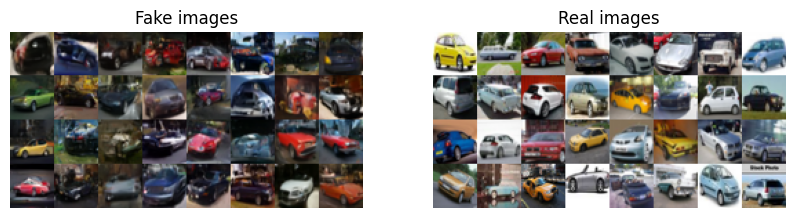

In [264]:
import matplotlib.pyplot as plt
from diffusers.utils import make_image_grid

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

fakes = [transforms.ToPILImage()(image) for image in fake_images[:32]]
grid = make_image_grid(fakes, rows=4, cols=8)
axes[0].imshow(grid); axes[0].set_title(f'Fake images')
axes[0].axis('off')

reals = [transforms.ToPILImage()(image) for image in real_images[:32]]
grid = make_image_grid(reals, rows=4, cols=8)
axes[1].imshow(grid); axes[1].set_title(f'Real images')
axes[1].axis('off')